# Frequency domain decomposition

Frequency domain decomposition relies on modal expansion of the measured signal $y(t)$, i.e.

$y(t) = Q z(t)$

where $Q=[q_1, q_2, \cdots, q_n]$ is the modal matrix with modes $q_i$ as columns and $z(t)$ is the modal coordinate. The correlation matrix then becomes 

$R_{yy}(\tau) = E[y(t) y(t+\tau)] = Q R_{zz}(\tau)Q^H$

and taking the fourier transform of the correlation matrix yields the PSD matrix

$G_{yy}(f) = Q G_{zz}(f) Q^H$

where $G_{pp}$ is a diagonal matrix due to the orthogonality of the modal coordinates. The PSD matrix can be decomposed by a singular value decomposition (SVD), which for a positive definite hermittian matrix is given by

$G_{yy}(f) = U(f) S(f) U(f)^H$

where U(f) is a unitary matrix holding the singular vectors and S(f) is a diagonal matrix holding the singular values. Upon comparison of the two equations above we find that S(f) correspond to the diagonal PSD matrix of the modal coordinates G_{zz}(f). 

Furthermore, the singular vectors U(f) correspond to the singular values in S(f). Since the peaks in the PSD correspond to the natural frequencies of the system and the frequencies of the uncoupled SDOF systems in modal coordinates, the singular vector that correspond to the largest singular value at the peaks correspond to the modal vector $q_i$. 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import strid
from scipy.signal import csd, find_peaks

First we create a measured signal, we use a shear frame and apply a initial displacement d0 and perform FDD on the free vibration acceleration signal.

In [3]:
sf = strid.utils.ShearFrame(5, 1e3, 1e6)
sf.set_rayleigh_damping_matrix([5, 50], [.01]*2)
M, C, K = sf.M, sf.C, sf.K
fs = 500
dt = 1/fs
T = 100 #s

n = sf.n
F = np.zeros((n, int(T*fs)))
v0 = np.zeros(n)
d0 = np.random.normal(size=n) * 10 + 100

A, V, D = strid.generalized_alpha_method(M, C, K, F, dt, d0, v0, rho=1.)


We add some noise to the measure

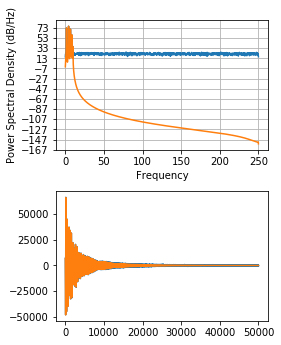

In [4]:
Am = A + np.random.normal(0, A.std()/20, size=A.shape)

nfft = 2**12
fig, axes = plt.subplots(nrows=2, figsize=np.array([1, 2/1.618])*10/2.5)
for i in range(2):
    Ai, lab = [(Am, "noisy signal"), (A, "signal")][i]
    axes[0].psd(Ai[-1], Fs=fs, NFFT=nfft, label=lab)
    axes[1].plot(Ai[-1])
fig.tight_layout()

We then compute the PSD matrix

In [5]:
PSD = strid.utils.find_psd_matrix(Am, nperseg=nfft)
f = strid.utils.get_frequency_vector(fs, PSD.shape[0])

In [6]:
PSD.shape

(2049, 5, 5)

and take the SVD of the PSD matrix

In [7]:
_, S, Q = np.linalg.svd(PSD)

/home/gunnstein/.local/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 50)

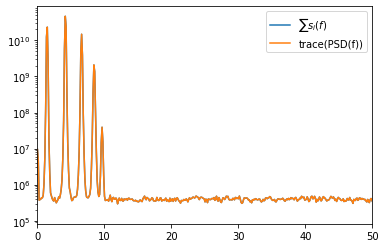

In [8]:
plt.semilogy(f, np.sum(S, axis=1))
plt.semilogy(f, np.trace(PSD, axis1=1, axis2=2))
plt.legend(["$\sum s_i(f)$", "trace(PSD(f))"])
plt.xlim(0, 50)

(0, 50)

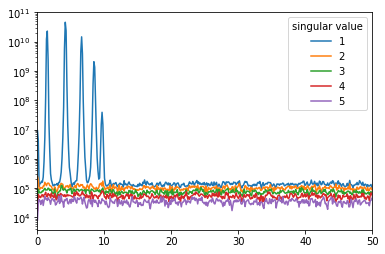

In [9]:
plt.semilogy(f, S,)
plt.legend([str(i+1) for i in range(S.shape[1])], title='singular value')
plt.xlim(0, 50)

from the plot above we see that the first singular value, i.e. the largest singular value, has five peaks, while none of the other singular values have distinguishable peaks. The natural frequencies and corresponding mode shapes are therefore the singular value peaks and corresponding singular vector. 

Below we see that the error between the estimated and true frequency and the MAC value between the estimated and true mode shapes and it is clear that there is good agreement between estimated and theoretical results.

i | f err |  MAC  
--+-------+-------
1 |  2.3% | 100.0%
2 | -0.7% | 100.0%
3 |  0.0% | 100.0%
4 | -0.5% | 100.0%
5 | -0.2% |  99.9%


Text(0, 0.5, 'PSD')

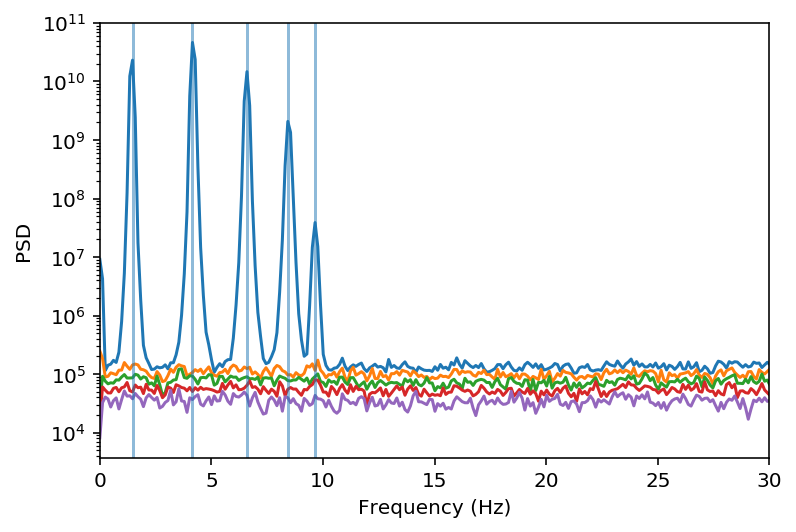

In [10]:
ks, props = find_peaks(S[:, 0], height=5e5)
plt.figure(dpi=144)
plt.semilogy(f, S)
print("i | {0:^5s} | {1:^6s}".format("f err", "MAC"))
print("-"*2 + "+" + "-"*7 + "+" + "-"*7)
res = []
for i, k in enumerate(ks):
    plt.axvline(f[k], alpha=.5)
    f_est = f[k]
    f_true = sf.get_natural_frequency(i+1) / (2*np.pi)
    err_f = (f_est - f_true)/f_true
    q_true = sf.get_mode_shape(i+1)
    q_est = Q[k, 0]
    res.append((f_est, q_est.real))
    MAC = strid.utils.find_modal_assurance_criterion(q_true, q_est)
    print(f"{i+1} | {err_f:>5.1%} | {MAC:>6.1%}")    
plt.xlim(0, 30)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")


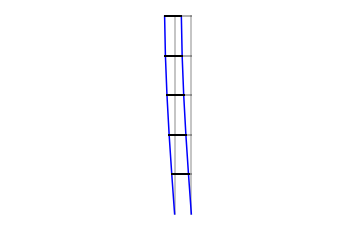

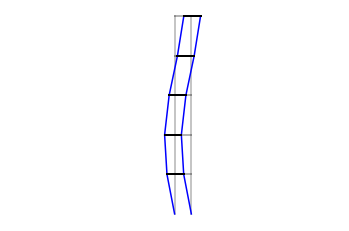

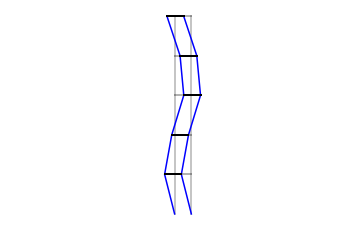

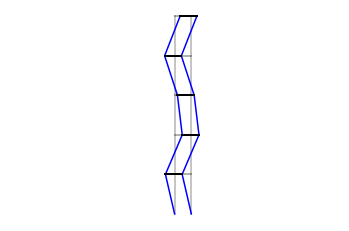

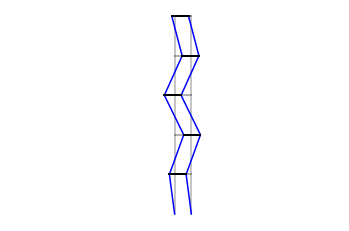

In [11]:
w = .1
for fi, qi in res:
    
    plt.figure()
    for s in [0, .1]:
        x = np.r_[0, qi]*s 
        y = [*range(x.size)]
        if s==0:
            col = (0, 0, 0, .3)
        else:
            col = (0, 0, 1, 1.)
        plt.plot(x, y, color=col)
        plt.plot(x+w, y, color=col)
        for i, xi in enumerate(x):
            if i == 0:
                continue
            plt.plot([xi, xi+w], [i]*2, 'k', lw=2, alpha=col[-1])
    plt.xlim(-1, 1)
    plt.axis('off')

In [18]:
import nptdms

In [19]:
%ls "C:/data"

 Volume in drive C has no label.
 Volume Serial Number is 14BC-4730

 Directory of C:\data

02/27/2020  03:00 PM    <DIR>          .
02/27/2020  03:00 PM    <DIR>          ..
02/27/2020  02:59 PM        18,795,921 2020-02-27-12-21-16Z.tdms
02/27/2020  03:00 PM         4,058,961 2020-02-27-12-21-16Z.tdms_index
02/27/2020  02:58 PM           703,478 master.tdms
02/27/2020  02:59 PM           189,398 master.tdms_index
               4 File(s)     23,747,758 bytes
               2 Dir(s)  492,113,027,072 bytes free


In [20]:
tdms_file = nptdms.TdmsFile("C:/data/2020-02-27-12-21-16Z.tdms")

In [21]:
tdms_file.groups()

['metadata.sensor.mod1.ch00.name', 'strain_data', 'acceleration_data']

In [22]:
tdms_file.group_channels("acceleration_data")

[<TdmsObject with path /'acceleration_data'/'timestamp'>,
 <TdmsObject with path /'acceleration_data'/'A00x'>,
 <TdmsObject with path /'acceleration_data'/'A00y'>,
 <TdmsObject with path /'acceleration_data'/'A00z'>,
 <TdmsObject with path /'acceleration_data'/'A01x'>,
 <TdmsObject with path /'acceleration_data'/'A01y'>,
 <TdmsObject with path /'acceleration_data'/'A01z'>,
 <TdmsObject with path /'acceleration_data'/'A02x'>,
 <TdmsObject with path /'acceleration_data'/'A02y'>,
 <TdmsObject with path /'acceleration_data'/'A02z'>,
 <TdmsObject with path /'acceleration_data'/'A03x'>,
 <TdmsObject with path /'acceleration_data'/'A03y'>,
 <TdmsObject with path /'acceleration_data'/'A03z'>,
 <TdmsObject with path /'acceleration_data'/'A04x'>,
 <TdmsObject with path /'acceleration_data'/'A04y'>,
 <TdmsObject with path /'acceleration_data'/'A04z'>,
 <TdmsObject with path /'acceleration_data'/'A05x'>,
 <TdmsObject with path /'acceleration_data'/'A05y'>,
 <TdmsObject with path /'acceleration_dat

In [23]:
y = tdms_file.group_channels("acceleration_data")[1].data

In [24]:
t = tdms_file.object("acceleration_data", "timestamp").data * 1e-9
dt = t[2]-t[1]
fs = 1/dt
Y = []
metadata = []

for ch in tdms_file.group_channels("acceleration_data"):
    if "A" not in ch.channel:
        continue
    if "x" in ch.channel:
        continue
    Y.append(ch.data)
    props = ["name", "position", "orientation"]
    metadata.append([ch.properties[k] for k in props])
Y = np.array(Y)

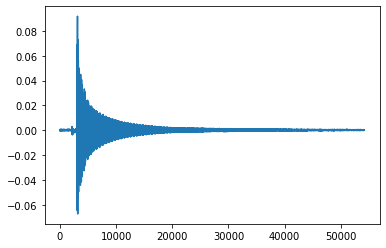

In [25]:
plt.plot(y)

In [26]:
PSD = strid.utils.find_psd_matrix(Y, nperseg=2**10)
f = strid.utils.get_frequency_vector(fs, PSD.shape[0])

In [27]:
_, s, Q = np.linalg.svd(PSD)

0 |  0.63 Hz
1 |  8.75 Hz
2 | 17.50 Hz
3 | 26.25 Hz
4 | 43.75 Hz
5 | 50.63 Hz
6 | 55.63 Hz
7 | 61.88 Hz
8 | 80.63 Hz
9 | 97.50 Hz
10 |115.63 Hz
11 |133.75 Hz
12 |141.25 Hz
13 |149.38 Hz
14 |156.25 Hz
15 |177.50 Hz
16 |186.25 Hz
17 |195.00 Hz
18 |211.25 Hz
19 |222.50 Hz
20 |236.25 Hz
21 |246.25 Hz
22 |255.63 Hz
23 |268.13 Hz
24 |276.88 Hz
25 |278.13 Hz
26 |286.25 Hz
27 |302.50 Hz
28 |315.01 Hz


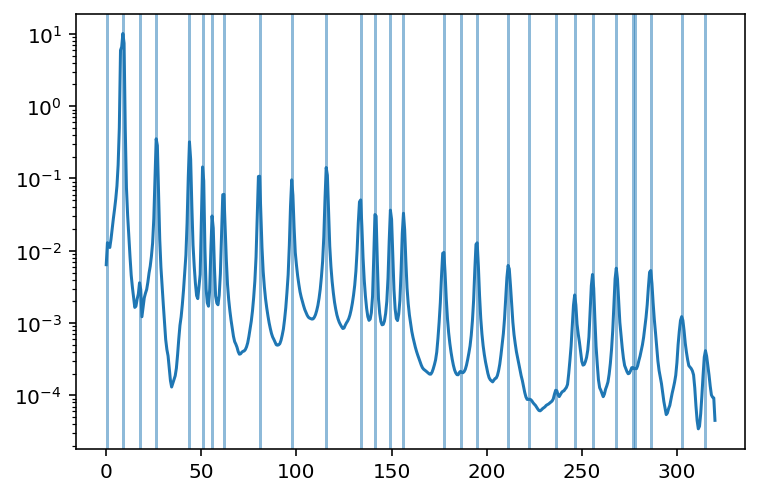

In [30]:
ks, props = find_peaks(s[:, 0])
ks1, props = find_peaks(s[:, 1])
plt.figure(dpi=144)
plt.semilogy(f, s[:, 0])

for i, k in enumerate(ks):
    plt.axvline(f[k], alpha=.5)
    f_est = f[k]
    print(f"{i} |{f_est:>6.2f} Hz")
    


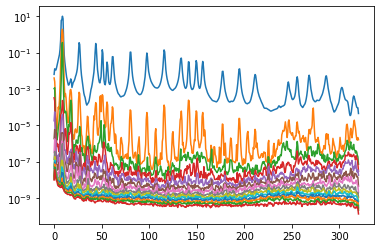

In [31]:
for si in s.T:
    plt.semilogy(f, si)